In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from itertools import combinations
import os

In [90]:
def stitch_pair(img_src_path, img_des_path):
    if type(img_src_path) is not np.ndarray:
        A = cv2.imread(img_src_path)
    else:
        A = img_src_path
    B = cv2.imread(img_des_path)

    A_gray = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
    B_gray = cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)

    # Using Harris corner detector on grayscale images A and B
    A_corners = cv2.cornerHarris(A_gray, blockSize=2, ksize=3, k=0.05)
    B_corners = cv2.cornerHarris(B_gray, blockSize=2, ksize=3, k=0.05)

    # Threshold to get the corners
    A_corners = np.argwhere(A_corners > 0.01 * A_corners.max())
    B_corners = np.argwhere(B_corners > 0.01 * B_corners.max())

    # Convert corners to keypoints
    A_kp = [cv2.KeyPoint(x=float(c[1]), y=float(c[0]), size=5 * 1.5) for c in A_corners]
    B_kp = [cv2.KeyPoint(x=float(c[1]), y=float(c[0]), size=5 * 1.5) for c in B_corners]

    # SIFT keypoint detector
    sift = cv2.SIFT_create()

    _, A_desc = sift.compute(A_gray, A_kp)
    _, B_desc = sift.compute(B_gray, B_kp)

    # Brute Force Matcher to find the k-nearest neighbors for each descriptor. Additionally, select the top 200 matches
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(A_desc, B_desc)
    matches = sorted(matches, key=lambda x: x.distance)[:200]


    # RANSAC algorithm
    src_pts = np.float32([ A_kp[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([ B_kp[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 0.3, maxIters = 5000)

    # Compute corners
    height1, width1 = A.shape[:2]
    height2, width2 = B.shape[:2]
    corners_B = np.float32([[0, 0], [width2, 0], [width2, height2], [0, height2]]).reshape(-1, 1, 2)

    # 
    transformed_corners_B = cv2.perspectiveTransform(corners_B, H)
    transformed_corners_B = transformed_corners_B.reshape(-1, 2)

    # Output panorama size
    all_corners = np.vstack((transformed_corners_B, [[0, 0], [width1, 0], [width1, height1], [0, height1]]))
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel())
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel())

    # Calculate and apply translation matrix against the homography matrix
    translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H_translation = translation @ H

    # Create the panorama canvas
    panorama_width = x_max - x_min
    panorama_height = y_max - y_min
    panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.uint8)

    # Warp B using the updated homography
    warped_B = cv2.warpPerspective(B, H_translation, (panorama_width, panorama_height))

    # Place A directly on the canvas
    panorama[-y_min:height1 - y_min, -x_min:width1 - x_min] = A

    # Blend the images
    mask = (warped_B > 0)
    panorama[mask] = warped_B[mask]
    
    return panorama

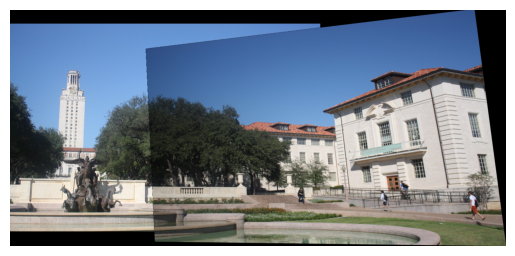

In [91]:
panorama = stitch_pair('./data/uttower_left.jpg', './data/uttower_right.jpg')

plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [92]:
def find_stitch_order(imgs):
    matches_inliers = []

    for i, j in combinations(range(len(imgs)), 2):
        
        A = cv2.imread(imgs[i])
        B = cv2.imread(imgs[j])

        A_gray = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
        B_gray = cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)

        # Using Harris corner detector on grayscale images A and B
        A_corners = cv2.cornerHarris(A_gray, blockSize=2, ksize=3, k=0.05)
        B_corners = cv2.cornerHarris(B_gray, blockSize=2, ksize=3, k=0.05)

        # Threshold to get the corners
        A_corners = np.argwhere(A_corners > 0.01 * A_corners.max())
        B_corners = np.argwhere(B_corners > 0.01 * B_corners.max())

        # Convert corners to keypoints
        A_kp = [cv2.KeyPoint(x=float(c[1]), y=float(c[0]), size=5 * 1.5) for c in A_corners]
        B_kp = [cv2.KeyPoint(x=float(c[1]), y=float(c[0]), size=5 * 1.5) for c in B_corners]

        # SIFT keypoint detector
        sift = cv2.SIFT_create()

        _, A_desc = sift.compute(A_gray, A_kp)
        _, B_desc = sift.compute(B_gray, B_kp)

        # Brute Force Matcher to find the k-nearest neighbors for each descriptor. Additionally, select the top 200 matches
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(A_desc, B_desc)
        matches = sorted(matches, key=lambda x: x.distance)[:200]

        # RANSAC algorithm
        src_pts = np.float32([ A_kp[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
        dst_pts = np.float32([ B_kp[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

        _, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 0.3, maxIters = 5000)
        num_inliers = np.sum(mask)  # Count inliers

        # Store the result
        matches_inliers.append((i, j, num_inliers))
    
    # Sort pairs by number of inliers (descending order)
    matches_inliers.sort(key=lambda x: x[2], reverse=True)
    
    # Return the ordered list of pairs
    return [(i, j) for i, j, _ in matches_inliers]

In [93]:
def stitch_multi(img_paths):
    # Determine stitching order
    stitch_order = find_stitch_order(img_paths)

    # Start stitching the first pair
    if stitch_order is None:
        return

    i, j = stitch_order[0]
    stitched = stitch_pair(img_paths[i], img_paths[j])

    # Iteratively stitch remaining images
    for _, k in stitch_order[1:]:
        stitched = stitch_pair(stitched, img_paths[k])

    return stitched


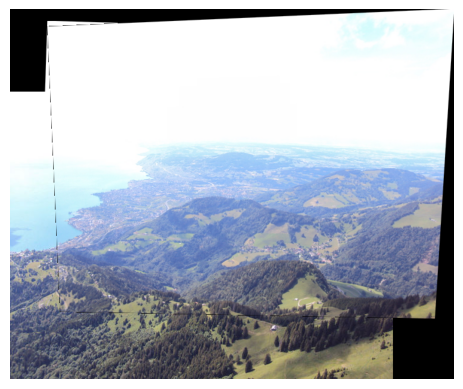

In [97]:
# img_dir = './data/hill/'
img_dir = './data/ledge/'
# img_dir = './data/pier/'
img_paths = [os.path.join(img_dir, img_path.lower()) for img_path in os.listdir(img_dir)]

panorama = stitch_multi(img_paths)

if panorama is not None:
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()